In [23]:
import csv
import dataset
import matplotlib.pyplot as plt
import midi
import numpy as np
import pathlib
import similarity
import tqdm
from typing import List, Tuple

In [24]:
DATASET_ROOT = "../dataset/newbie-dataset"

SLICE_DURATION = 5  # sec
EXPANSION_RATE = 1.5
FRAME_PER_SECOND = 20  # Hz
SETTLING_FRAME = 10
COMPENSATION_FRAME = 0

QUEUE_SIZE = 8

NUM_SAMPLES = 100

SAVE_ROOT = pathlib.Path("./save")
if not SAVE_ROOT.exists():
    SAVE_ROOT.mkdir(exist_ok=True, parents=True)

In [25]:
generator = dataset.new_generator(root=DATASET_ROOT,
                                  slice_duration=SLICE_DURATION,
                                  expansion_rate=EXPANSION_RATE,
                                  frame_per_second=FRAME_PER_SECOND,
                                  note_scale=0.90,
                                  shuffle=True)

In [26]:
# pos/neg-similarities: [histogram_distance, timewarping_distance, length_ratio]
pos_similarities: List[Tuple[float, float, float]] = []
neg_similarities: List[Tuple[float, float, float]] = []

In [27]:
prev_perfs: List[np.ndarray] = [None] * QUEUE_SIZE

In [28]:
decay_fn = midi.get_decay_fn("linear", settling_frame=SETTLING_FRAME)

In [29]:
with open(SAVE_ROOT / "pos.csv", "w", encoding="utf-8") as f1, \
     open(SAVE_ROOT / "neg.csv", "w", encoding="utf-8") as f2:
    pos_csvfile = csv.writer(f1, delimiter=",", quotechar="|")
    pos_csvfile.writerow(["Histogram distance", "Timewarping distance", "Length ratio"])

    neg_csvfile = csv.writer(f2, delimiter=",", quotechar="|")
    neg_csvfile.writerow(["Histogram distance", "Timewarping distance", "Length ratio"])

    try:
        for idx in tqdm.trange(NUM_SAMPLES, desc="Measuring similarities..."):
            score, perf, _ = next(generator)
            score_len = score.shape[-1]
            perf_len = perf.shape[-1]
            pos_histogram_distance, pos_timewarping_distance = similarity.measure(score, perf,
                                                                                  compensation_frame=COMPENSATION_FRAME,
                                                                                  decay_fn=decay_fn, subsequence=True)
            pos_length_ratio = perf_len / (score_len + 1e-7)
            pos_csvfile.writerow([pos_histogram_distance, pos_timewarping_distance, pos_length_ratio])
            pos_similarities.append((pos_histogram_distance, pos_timewarping_distance, pos_length_ratio))
            
            if isinstance(prev_perfs[0], np.ndarray):
                prev_perf = prev_perfs[0]
                prev_perf_len = prev_perf.shape[-1]
                neg_histogram_distance, neg_timewarping_distance = similarity.measure(score, prev_perf,
                                                                                      compensation_frame=COMPENSATION_FRAME,
                                                                                      decay_fn=decay_fn, subsequence=True)
                neg_length_ratio = prev_perf_len / (score_len + 1e-7)
                neg_csvfile.writerow([neg_histogram_distance, neg_timewarping_distance, neg_length_ratio])
                neg_similarities.append((neg_histogram_distance, neg_timewarping_distance, neg_length_ratio))

            prev_perfs.pop(0)
            prev_perfs.append(perf)
    except StopIteration:
        print(f"Loading dataset is finished at iteration {idx}.")

Measuring similarities...:  48%|████▊     | 48/100 [01:04<01:10,  1.35s/it]

Loading dataset is finished at iteration 48.


In [30]:
pos_similarities = np.array(pos_similarities)
neg_similarities = np.array(neg_similarities)

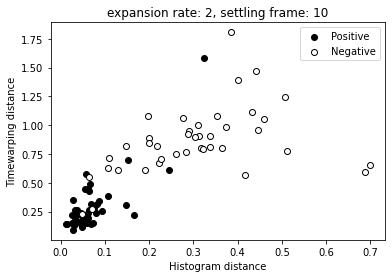

In [31]:
fig = plt.figure("scatter_2d")
ax = fig.gca()
ax.set_title(f"expansion rate: {EXPANSION_RATE}, settling frame: {SETTLING_FRAME}")
ax.set_xlabel("Histogram distance")
ax.set_ylabel("Timewarping distance")
ax.scatter(pos_similarities[:, 0], pos_similarities[:, 1], c="k", label="Positive")
ax.scatter(neg_similarities[:, 0], neg_similarities[:, 1], c="w", edgecolors="k", label="Negative")
plt.legend()
plt.show()

C:\Users\kaparoo\AppData\Local\Temp/ipykernel_3628/3206662465.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection="3d")


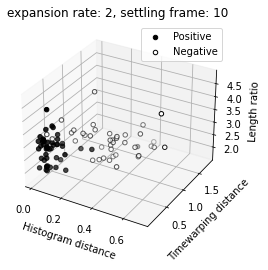

In [32]:
fig = plt.figure("scatter_3d")
ax = fig.gca(projection="3d")
ax.set_title(f"expansion rate: {EXPANSION_RATE}, settling frame: {SETTLING_FRAME}")
ax.set_xlabel("Histogram distance")
ax.set_ylabel("Timewarping distance")
ax.set_zlabel("Length ratio")
ax.scatter(pos_similarities[:,0], pos_similarities[:,1], pos_similarities[:,2], c="k", label="Positive")
ax.scatter(neg_similarities[:,0], neg_similarities[:,1], neg_similarities[:,2], c="w", edgecolors="k", label="Negative")
plt.legend()
plt.show()

In [33]:
print(pos_similarities)

[[0.03229829 0.26590562 1.84615385]
 [0.06662767 0.48771311 2.06796116]
 [0.24558827 0.61325724 2.64423077]
 [0.03139876 0.13698862 2.50485437]
 [0.0284041  0.35270248 2.58653846]
 [0.05675741 0.15051153 2.0776699 ]
 [0.14727134 0.305279   2.03365385]
 [0.06198118 0.23512272 2.08252427]
 [0.07334673 0.15391329 4.42307692]
 [0.02660069 0.15012151 2.96116505]
 [0.04542813 0.23571412 2.83980582]
 [0.09469925 0.25488981 2.11057692]
 [0.01543749 0.13844414 2.09708738]
 [0.02986465 0.22163099 3.0625    ]
 [0.07593811 0.27757183 2.92561983]
 [0.03940549 0.22751115 2.05769231]
 [0.0877706  0.34553845 3.09223301]
 [0.06166765 0.44803297 3.10096154]
 [0.03802773 0.23369136 2.0776699 ]
 [0.06375338 0.42659006 2.75      ]
 [0.05902021 0.14904535 2.68932039]
 [0.16621257 0.22329943 2.78365384]
 [0.02608407 0.2222974  2.31067961]
 [0.03340862 0.1920232  2.97115384]
 [0.01194279 0.14637684 3.12135922]
 [0.10797607 0.38727351 2.80582524]
 [0.05065355 0.19343066 2.83653846]
 [0.02755711 0.09070478 2.92